## Import dependent libraries

In [1]:
from pandas import read_csv
from matplotlib import pyplot
import math
from numpy import concatenate, array
from pandas import DataFrame
from pandas import concat
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Model, model_from_json
from keras.layers import Input
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers.recurrent import LSTM
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.layers.core import Activation
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model

Using TensorFlow backend.


## Load dataset

In [2]:
dataset = read_csv('music_data.csv', header=0, index_col=0)
values = dataset.values
print(values[0])

[25456]


## Specify columns to plot

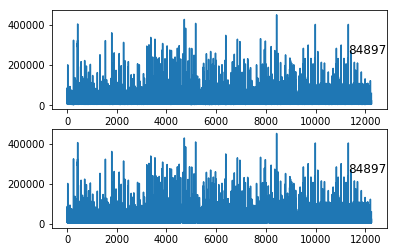

In [3]:
groups = [-1, 0]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1


pyplot.show()

## Convert series to supervised learning

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Encode and Scale the values

In [5]:
dataset = read_csv('music_data.csv', header=0)
values = dataset.values
print('values:', values[0:10])
# integer encode direction
# encoder = LabelEncoder()
# values[:, 0] = encoder.fit_transform(values[:, 0])
# print('encoded_values:', values[0:10])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning

values: [[   60 25456]
 [   59 14880]
 [   62 25820]
 [   60 21361]
 [   59 21153]
 [   60 26320]
 [   58 20404]
 [   57 86203]
 [   59 20645]
 [   57 19400]]


In [6]:
# specify the number of lag hours
n_hours = 10
n_features = 2
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)


(12236, 22)


In [7]:
values = reframed.values
n_train_hours = 9000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features


In [8]:
train_X, train_y_notes = train[:, :n_obs], train[:, -n_features]
train_y_length = train[:, -n_features -1]

test_X, test_y_notes = test[:, :n_obs], test[:, -n_features]
test_y_length = test[:, -n_features -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y_notes.shape, test_X.shape, test_y_notes.shape)


(9000, 10, 2) (9000,) (3236, 10, 2) (3236,)


In [9]:
visible = Input(name='input_main', shape=(train_X.shape[1], train_X.shape[2]))
hidden1 = LSTM(128, return_sequences=True)(visible)
batchNorm1 = BatchNormalization()(hidden1)
dropout1 = Dropout(0.5)(batchNorm1)

hidden2 = LSTM(128, return_sequences=True)(dropout1)
batchNorm2 = BatchNormalization()(hidden2)
dropout2 = Dropout(0.5)(batchNorm2)

#hidden3 = LSTM(512, return_sequences=True)(dropout2)
#batchNorm3 = BatchNormalization()(hidden3)
#dropout3 = Dropout(0.5)(batchNorm3)
#
#hidden4 = LSTM(512, return_sequences=True)(dropout3)
#batchNorm4 = BatchNormalization()(hidden4)
#dropout4 = Dropout(0.5)(batchNorm4)

#hidden5 = LSTM(256, return_sequences=True)(dropout4)
#batchNorm5 = BatchNormalization()(hidden5)
#dropout5 = Dropout(0.5)(batchNorm5)
#
#hidden6 = LSTM(256, return_sequences=True)(dropout5)
#batchNorm6 = BatchNormalization()(hidden6)
#dropout6 = Dropout(0.5)(batchNorm6)

hidden11 = LSTM(128)(dropout2)

output_notes = Dense(1, activation='sigmoid', name='output_notes')(hidden11)
output_length = Dense(1, activation='sigmoid', name='output_length')(hidden11)

model = Model(inputs=[visible], outputs=[output_notes, output_length])

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

callback_list = [reduce_lr]

optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mae', optimizer=optimizer)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_main (InputLayer)          (None, 10, 2)         0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 10, 128)       67072       input_main[0][0]                 
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 10, 128)       512         lstm_1[0][0]                     
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 10, 128)       0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [11]:
history = model.fit(
            {'input_main': train_X},
            {'output_notes': train_y_notes, 'output_length': train_y_length},
            validation_data=({'input_main': test_X},
                             {'output_notes': test_y_notes, 'output_length': test_y_length}), 
            verbose=2,
            shuffle=False,
            epochs=25, 
            batch_size=32)

Train on 9000 samples, validate on 3236 samples
Epoch 1/25
35s - loss: 0.2332 - output_notes_loss: 0.1597 - output_length_loss: 0.0735 - val_loss: 0.4390 - val_output_notes_loss: 0.1542 - val_output_length_loss: 0.2848
Epoch 2/25
39s - loss: 0.2017 - output_notes_loss: 0.1516 - output_length_loss: 0.0501 - val_loss: 0.1841 - val_output_notes_loss: 0.1324 - val_output_length_loss: 0.0517
Epoch 3/25
37s - loss: 0.2000 - output_notes_loss: 0.1506 - output_length_loss: 0.0495 - val_loss: 0.1801 - val_output_notes_loss: 0.1345 - val_output_length_loss: 0.0456
Epoch 4/25
36s - loss: 0.1981 - output_notes_loss: 0.1493 - output_length_loss: 0.0488 - val_loss: 0.1800 - val_output_notes_loss: 0.1350 - val_output_length_loss: 0.0450
Epoch 5/25
36s - loss: 0.1968 - output_notes_loss: 0.1484 - output_length_loss: 0.0484 - val_loss: 0.1783 - val_output_notes_loss: 0.1339 - val_output_length_loss: 0.0444
Epoch 6/25
36s - loss: 0.1954 - output_notes_loss: 0.1476 - output_length_loss: 0.0478 - val_loss

In [12]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


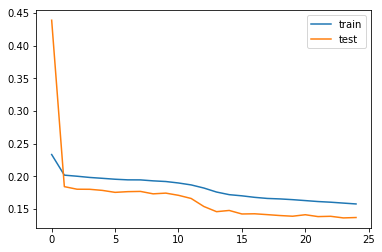

In [13]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()